In [1]:
#check erosion/deposition inside meadows
#not using min/max hcan with interval of certain days
#instead: mean daily volume change while hcan is above or below certain value.
#--> run SyltRomo/eroded_vol_intertidal_nochange_sav_two_hcan.py first
from netCDF4 import Dataset
import numpy as  np
import matplotlib.pyplot as plt

import math
import glob
import os.path
import sys
sys.path.insert(0, '/home/g/g260204/tools/python_skripts/SchismUtils/')
from schism_utils import read_data, sort_files
import h5py
import os.path

from matplotlib import rcParams
rcParams['figure.dpi'] = 300

import matplotlib as mpl
mpl.rc('hatch', color='k', linewidth=1)

In [2]:
p5pat = 'work/gg0877/g260204/data/pickle_files'
study = 'srm02x3x'
figname = 'srm02x3x'
hcanlim1 = 0.1
hcanlim2 = 0.02
h5pypath= '/work/gg0877/g260204/data/pickle_files/'
run_labels=['no sg','stat sg (ref)','var sg (ref)','stat sg (int)','var sg (int)']
colors =  ['tab:blue','tab:orange','tab:green','orangered','darkgreen']#['tab:blue','midnightblue','gold','tab:orange','wheat','tan','peru','tab:green','lightgreen','darkseagreen','darkgreen','teal']
plotpat = '/work/gg0877/g260204/sim_data/SR5yr/plots/plots/' 
if not os.path.exists(plotpat+figname):
    os.makedirs(plotpat+figname)

[array([ 42, 156]), array([207, 350])]
2010 min [ 42 156] max [207 350]
[array([ 22, 148]), array([211, 338])]
2011 min [ 22 148] max [211 338]
[array([ 17, 155]), array([222, 343])]
2012 min [ 17 155] max [222 343]
[array([ 29, 156]), array([215, 339])]
2013 min [ 29 156] max [215 339]
[array([ 20, 147]), array([200, 348])]
2014 min [ 20 147] max [200 348]
[array([ 15, 159]), array([221, 344])]
2015 min [ 15 159] max [221 344]


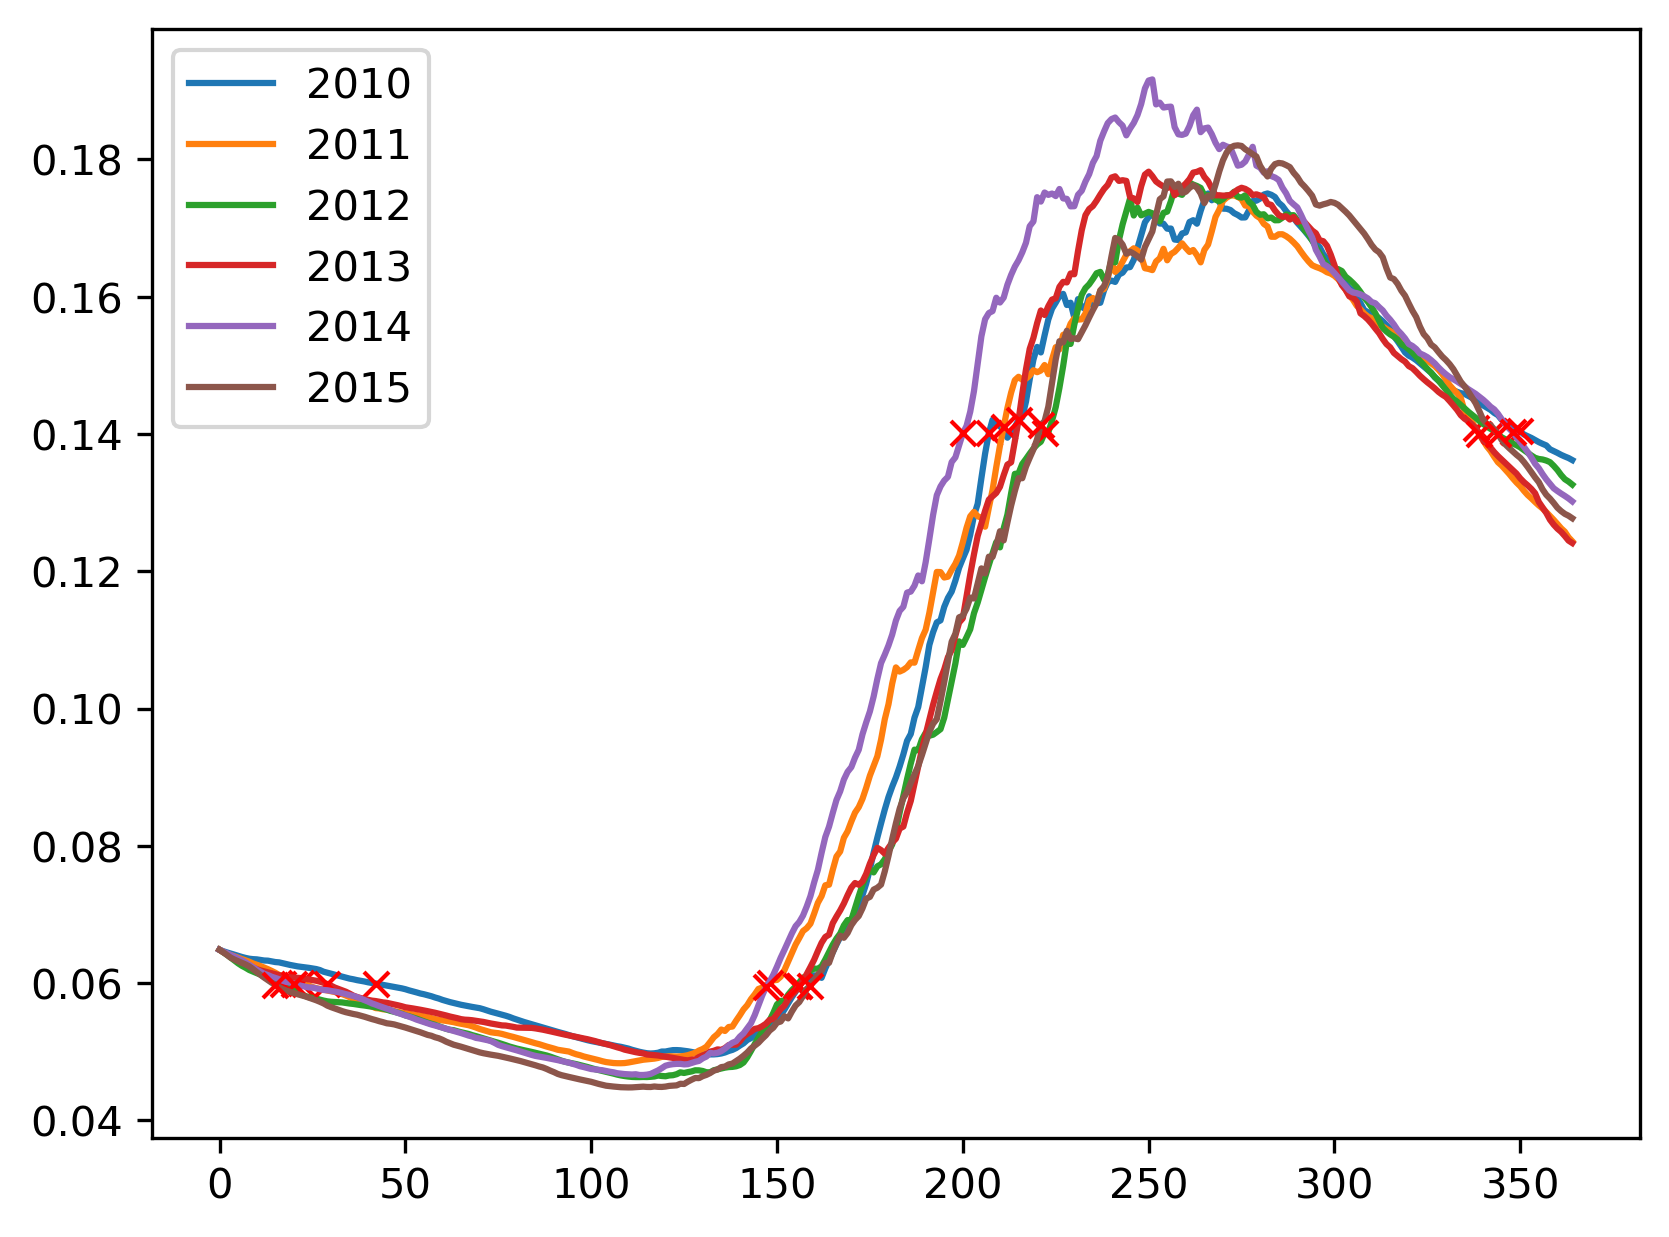

In [3]:
runs=['srm020','srm026','srm024','srm035','srm036']
canopyref = 'srm024'
#sim x years x hcan x season
s_year=2010
e_year=2016
all_erovol = np.zeros((len(runs),e_year-s_year,3,2))
all_last =  np.zeros((len(runs),e_year-s_year,3,2))
heights = ['nocan','midcan','highcan']
for year in range(2010,2016):
    fname = h5pypath + study + '_'+str(year)+'_intertidal_' + str(hcanlim1) + '_' + str(hcanlim2) + '.hdf5'
    f = h5py.File(fname,'r')
    #days hcan above threshold of 14 cm!
    hcan = np.array(f[canopyref+'_'+str(year)+'_hcan_highcan'])
    imax = np.where(hcan>0.14)[0][[0,-1]]
    imin = np.where(hcan<0.06)[0][[0,-1]]
    plt.plot(hcan,label=str(year))
    plt.plot([imin],hcan[[imin]],'xr')
    plt.plot([imax],hcan[[imax]],'xr')
    minmax = [imin,imax]
    print(minmax)
    print(year, 'min',imin,'max',imax)
    for run in range(0,len(runs)):
        for h in range(0,len(heights)):
            for s in range(0,2):
                #start
                varname = runs[run]+'_'+str(year)+'_'+heights[h]
                #print(varname, f[varname][-1])
                diff = -(f[varname][minmax[s][1]]-f[varname][minmax[s][0]])/(minmax[s][1]-minmax[s][0]) #invert because positive downward
                #write diff to array
                all_last[run,year-2010,h,s] = -f[varname][-1]
                all_erovol[run,year-2010,h,s]=diff
   
    plt.legend()
    #df = pd.DataFrame()
    #for title in f.keys():
    #    df[title]=np.array(h5py.File(h5pypath)[title])
    #f.close()

In [4]:
#mean over years w/ difference 
#sim x hcan x season
all_erovol = all_erovol-all_erovol[0,:,:,:]
mean_erovol = np.mean(all_erovol,1)
rmsd_erovol = np.sqrt(np.var(all_erovol,1))
mean_last = np.mean(all_last,1)
print('total volume change in areas:')
print('no seagrass: [low mid high all]',mean_last[0,:,1], np.sum(mean_last[0,:,1]))
print('static seagrass: [low mid high all]',mean_last[1,:,1],np.sum(mean_last[1,:,1]))
print('variable seagrass: [low mid high all]',mean_last[2,:,0],np.sum(mean_last[2,:,1]))

total volume change in areas:
no seagrass: [low mid high all] [271286.46971926 -13816.71060655  -2931.09660753] 254538.66250517857
static seagrass: [low mid high all] [220998.91385986  -5835.49919322  -1047.02071168] 214116.39395495932
variable seagrass: [low mid high all] [258498.36744705  -4135.62971873  -1632.44254585] 252730.29518247332


/tmp/ipykernel_558807/2135259342.py:31: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


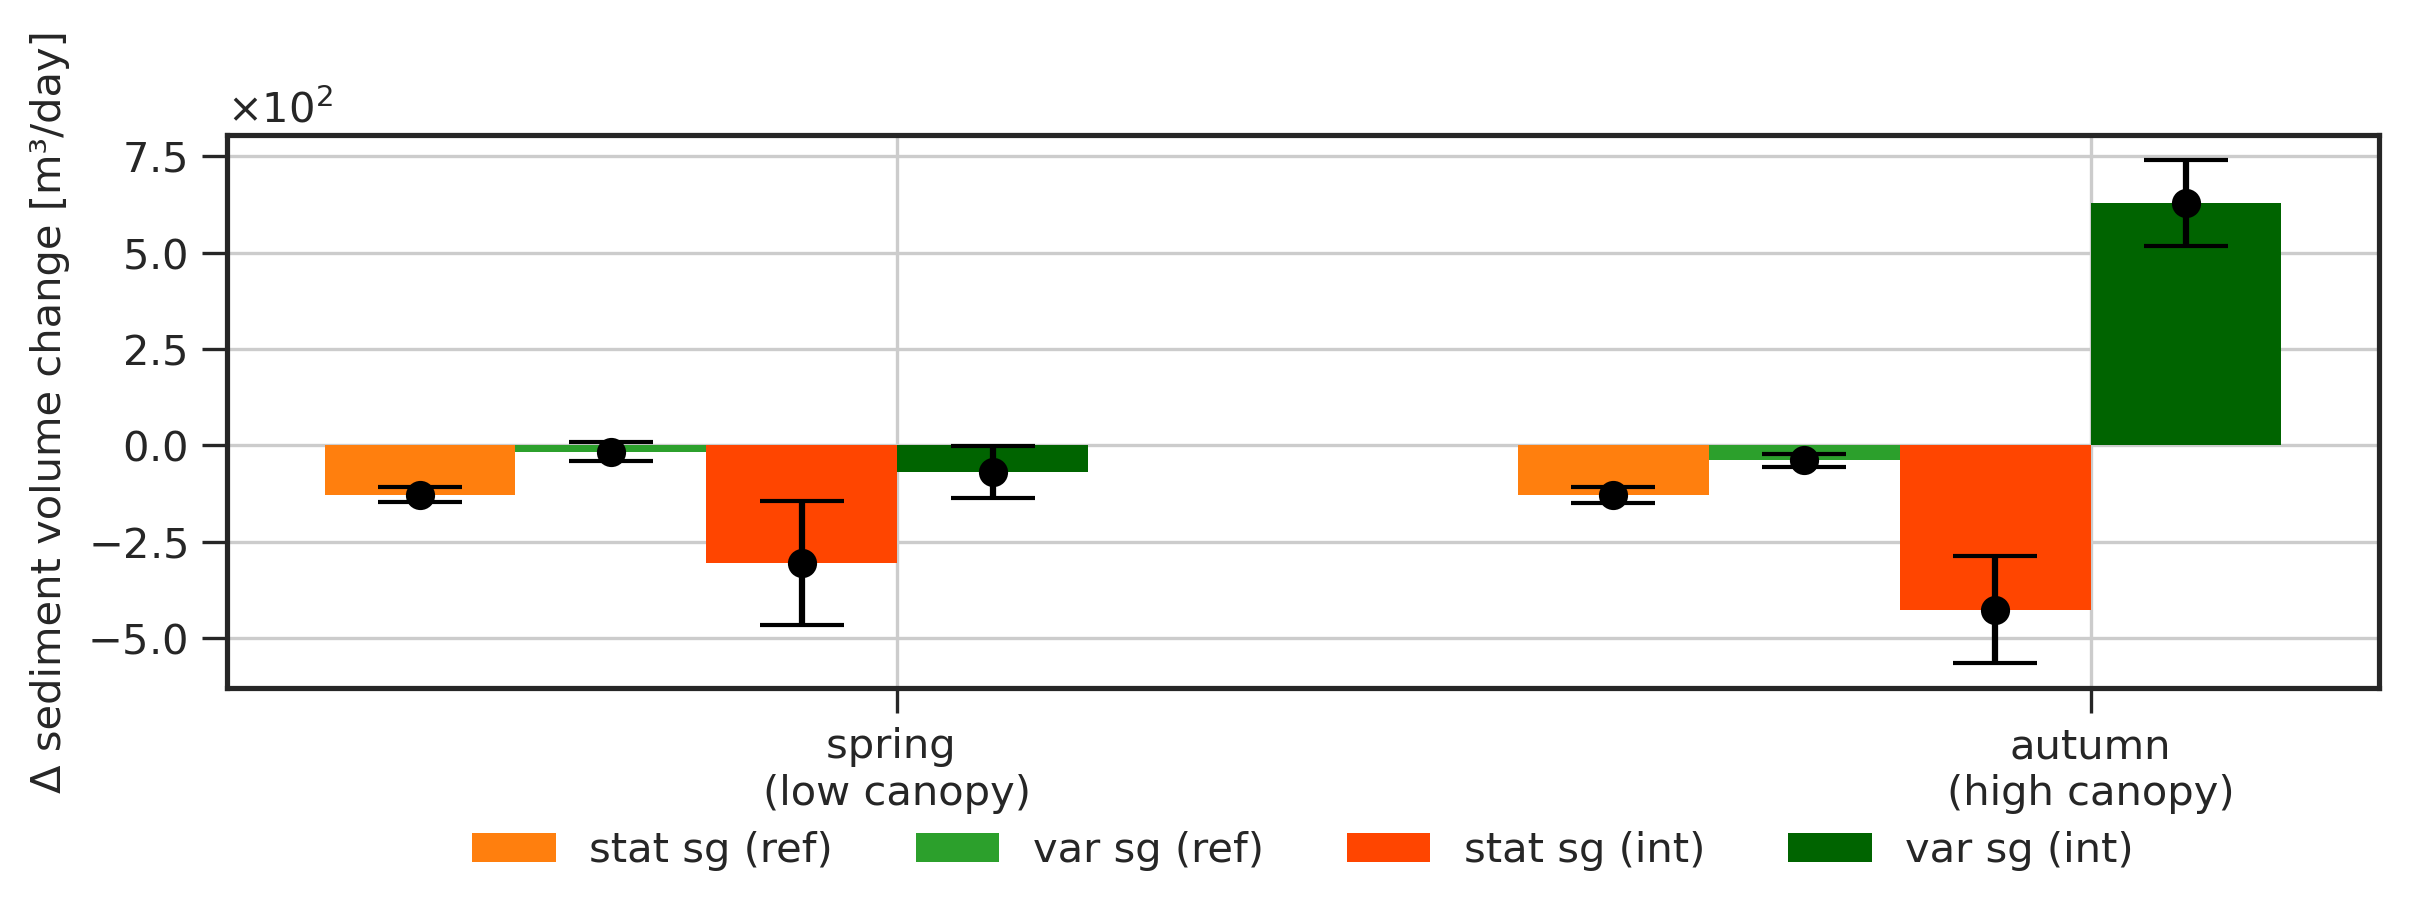

In [5]:
#all in one and pretty
#outside meadows

sections = ('spring \n(low canopy)','autumn\n(high canopy)')

x = np.arange(2)
width = (1-0.2)/len(runs)
multiplier = -1.5

plt.style.use('seaborn-ticks')
fig, ax = plt.subplots(layout='constrained')
fig.set_figheight(3.5)
fig.set_figwidth(8)
ax.grid()
for run in range(1,len(runs)):
    offset = width * multiplier
    rects = ax.bar(x+offset,mean_erovol[run,0,:],width,label=run_labels[run],color = colors[run])
    ax.errorbar(x+offset,mean_erovol[run,0,:],yerr=rmsd_erovol[run,0,:],fmt='o',color='k',capsize = 10)
    multiplier +=1
    
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel(u'Δ sediment volume change [m³/day]')
#ax.set_title('Volume change by season')
ax.set_xticks(x + width, sections)
#ax.set_ylim([-15,10])
ax.legend(loc='upper left', ncol=1)
ax.yaxis.get_major_formatter().set_powerlimits((0, 1))
#ax.yaxis.offsetText.set_fontsize(24)
ax.yaxis.get_major_formatter().set_useMathText('true')

plt.tight_layout()
# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.3,box.width, box.height * 0.7])
# Put a legend below current axis
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.4), fancybox=True, ncol=5)
plt.savefig(plotpat+ figname + '/daily_volume_change_intertidal_nocan_seasons_'+ heights[0]+'_diff.png')
    

/tmp/ipykernel_558807/2501915145.py:31: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


[0. 0. 0. 0. 0. 0.]


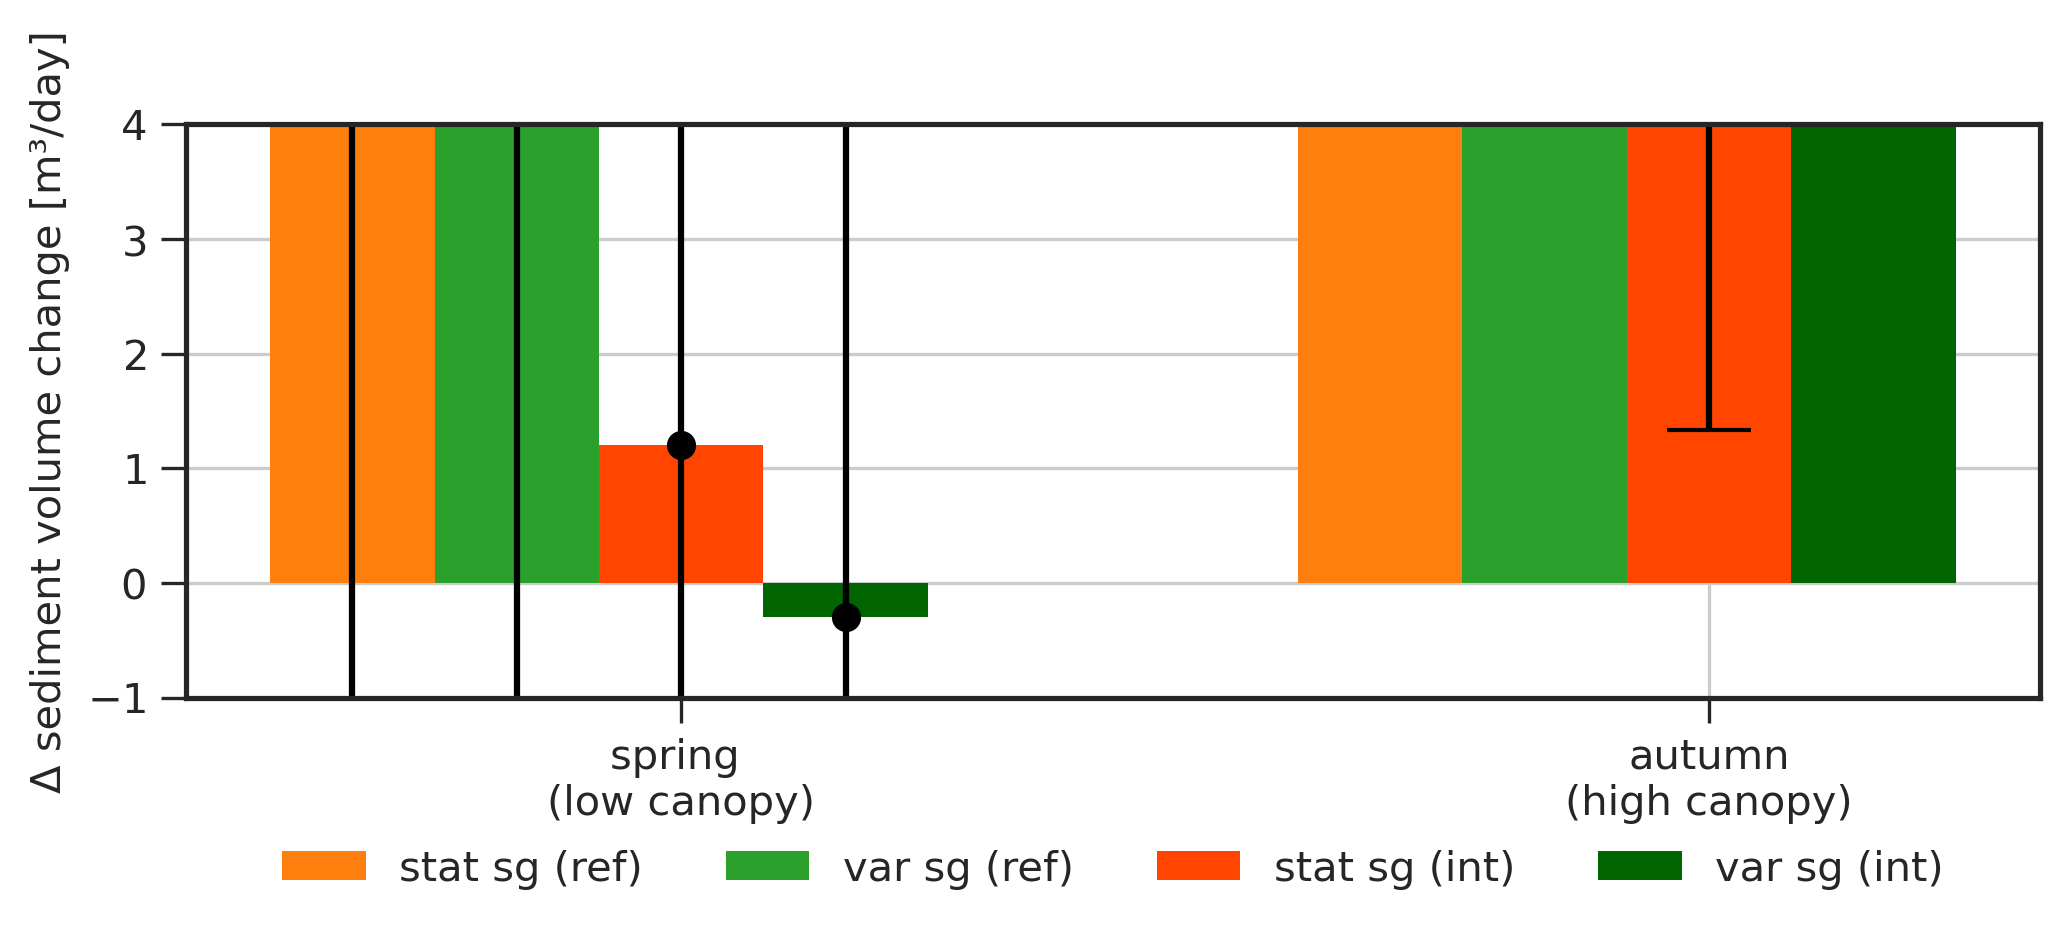

In [6]:
#all in one and pretty
#inside meadows, medium canopy height

sections = ('spring \n(low canopy)','autumn\n(high canopy)')

x = np.arange(2)
width = (1-0.2)/len(runs)
multiplier = -1

plt.style.use('seaborn-ticks')
fig, ax = plt.subplots(layout='constrained')
fig.set_figheight(3.5)
fig.set_figwidth(7)
ax.grid()
for run in range(1,len(runs)):
    offset = width * multiplier
    rects = ax.bar(x+offset,mean_erovol[run,1,:],width,label=run_labels[run],color = colors[run])    
    ax.errorbar(x+offset,mean_erovol[run,1,:],yerr=rmsd_erovol[run,1,:],fmt='o',color='k',capsize = 10)
    multiplier +=1
    
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel(u'Δ sediment volume change [m³/day]')
#ax.set_title('Volume change by season')
ax.set_xticks(x + width, sections)
ax.set_ylim([-1,4])
ax.legend(loc='lower right', ncol=1)
ax.yaxis.get_major_formatter().set_powerlimits((0, 1))
#ax.yaxis.offsetText.set_fontsize(24)
ax.yaxis.get_major_formatter().set_useMathText('true')

plt.tight_layout()
# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.3,box.width, box.height * 0.7])
# Put a legend below current axis
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.4), fancybox=True, ncol=5)

plt.savefig(plotpat+ figname + '/daily_volume_change_intertidal_nocan_seasons_'+ heights[1]+'_diff.png')

print(all_erovol[0,:,1,0])


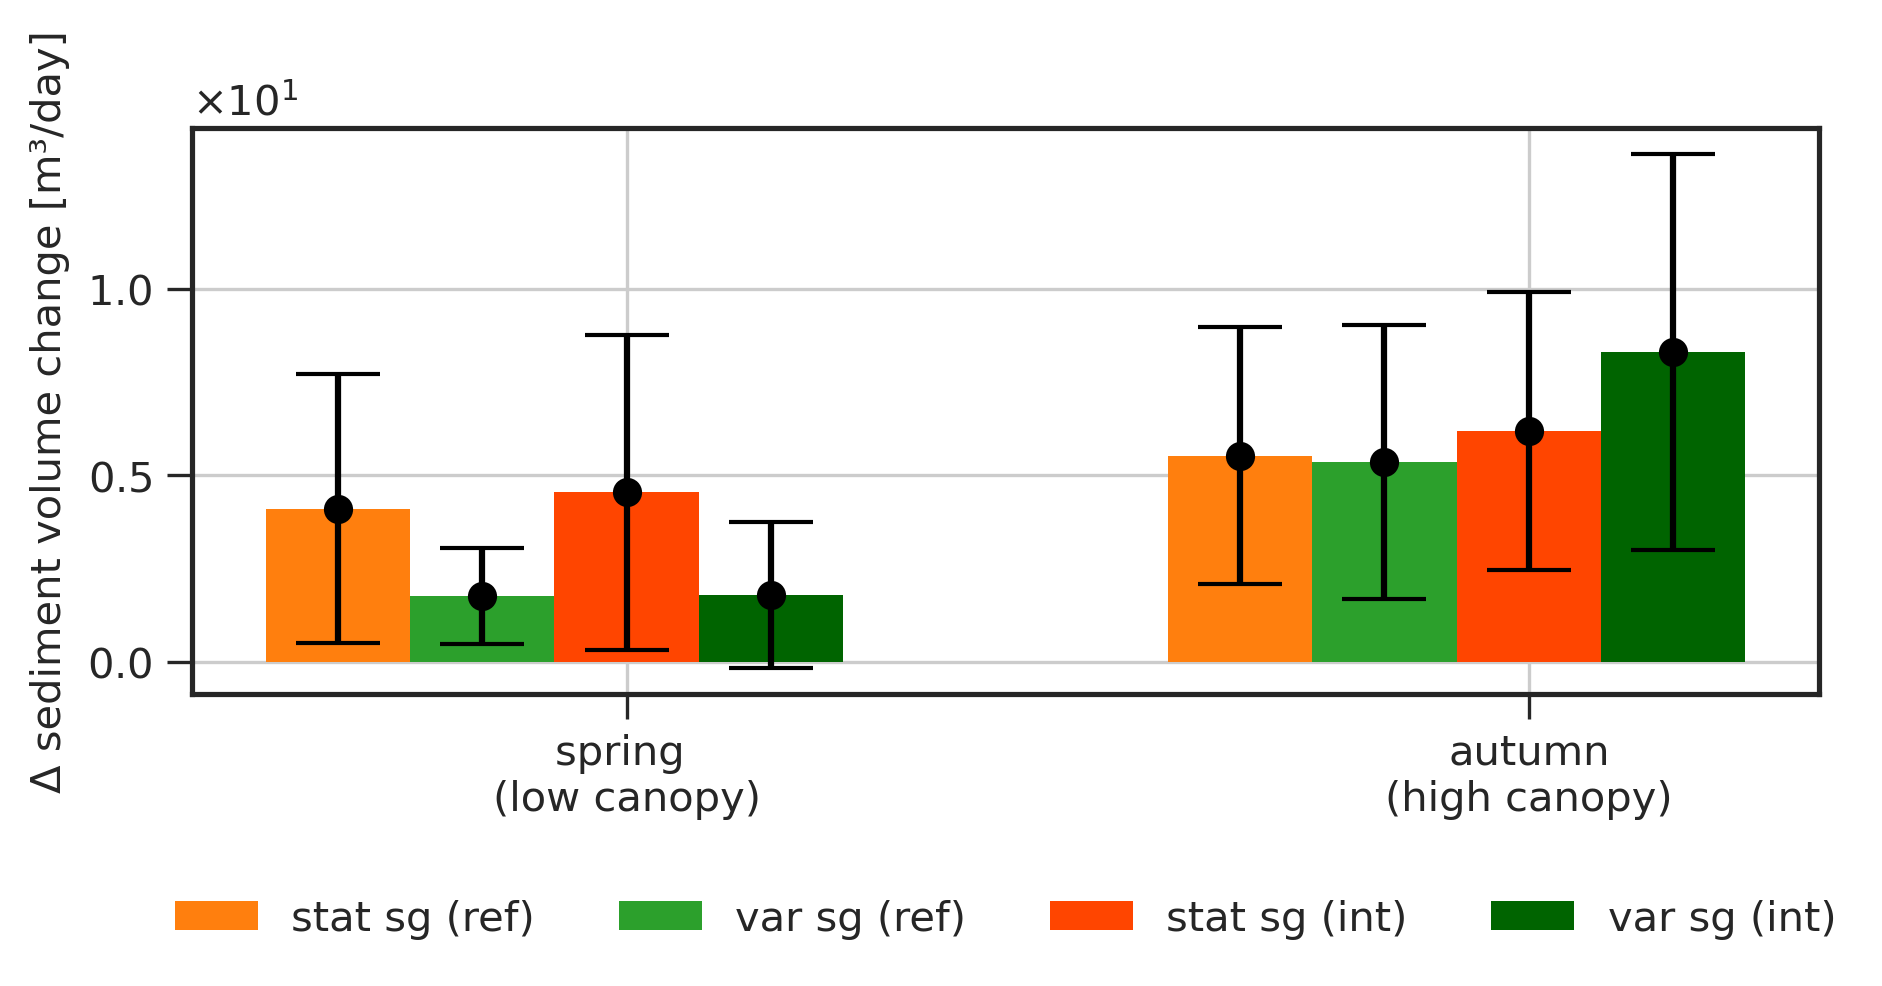

In [7]:
#all in one and pretty
#inside meadows, high canopy height

sections = ('spring \n(low canopy)','autumn\n(high canopy)')

x = np.arange(2)
width = (1-0.2)/len(runs)
multiplier = -1

plt.style.use('seaborn-ticks')
fig, ax = plt.subplots(layout='constrained')
fig.set_figheight(3.5)
fig.set_figwidth(7)
ax.grid()
for run in range(1,len(runs)):
    offset = width * multiplier
    rects = ax.bar(x+offset,mean_erovol[run,2,:],width,label=run_labels[run],color=colors[run])
    ax.errorbar(x+offset,mean_erovol[run,2,:],yerr=rmsd_erovol[run,2,:],fmt='o',color='k',capsize = 10)
    multiplier +=1
    
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel(u'Δ sediment volume change [m³/day]')
#ax.set_title('Volume change by season')
ax.set_xticks(x + width, sections)
#ax.set_ylim([-1,4])
ax.legend(loc='lower right', ncol=1)
ax.yaxis.get_major_formatter().set_powerlimits((0, 1))
#ax.yaxis.offsetText.set_fontsize(24)
ax.yaxis.get_major_formatter().set_useMathText('true')

#plt.tight_layout()
# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.3,box.width, box.height * 0.7])
# Put a legend below current axis
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.5), fancybox=True, ncol=5)
plt.savefig(plotpat+ figname + '/daily_volume_change_intertidal_nocan_seasons_'+ heights[2]+'diff_.png')
    

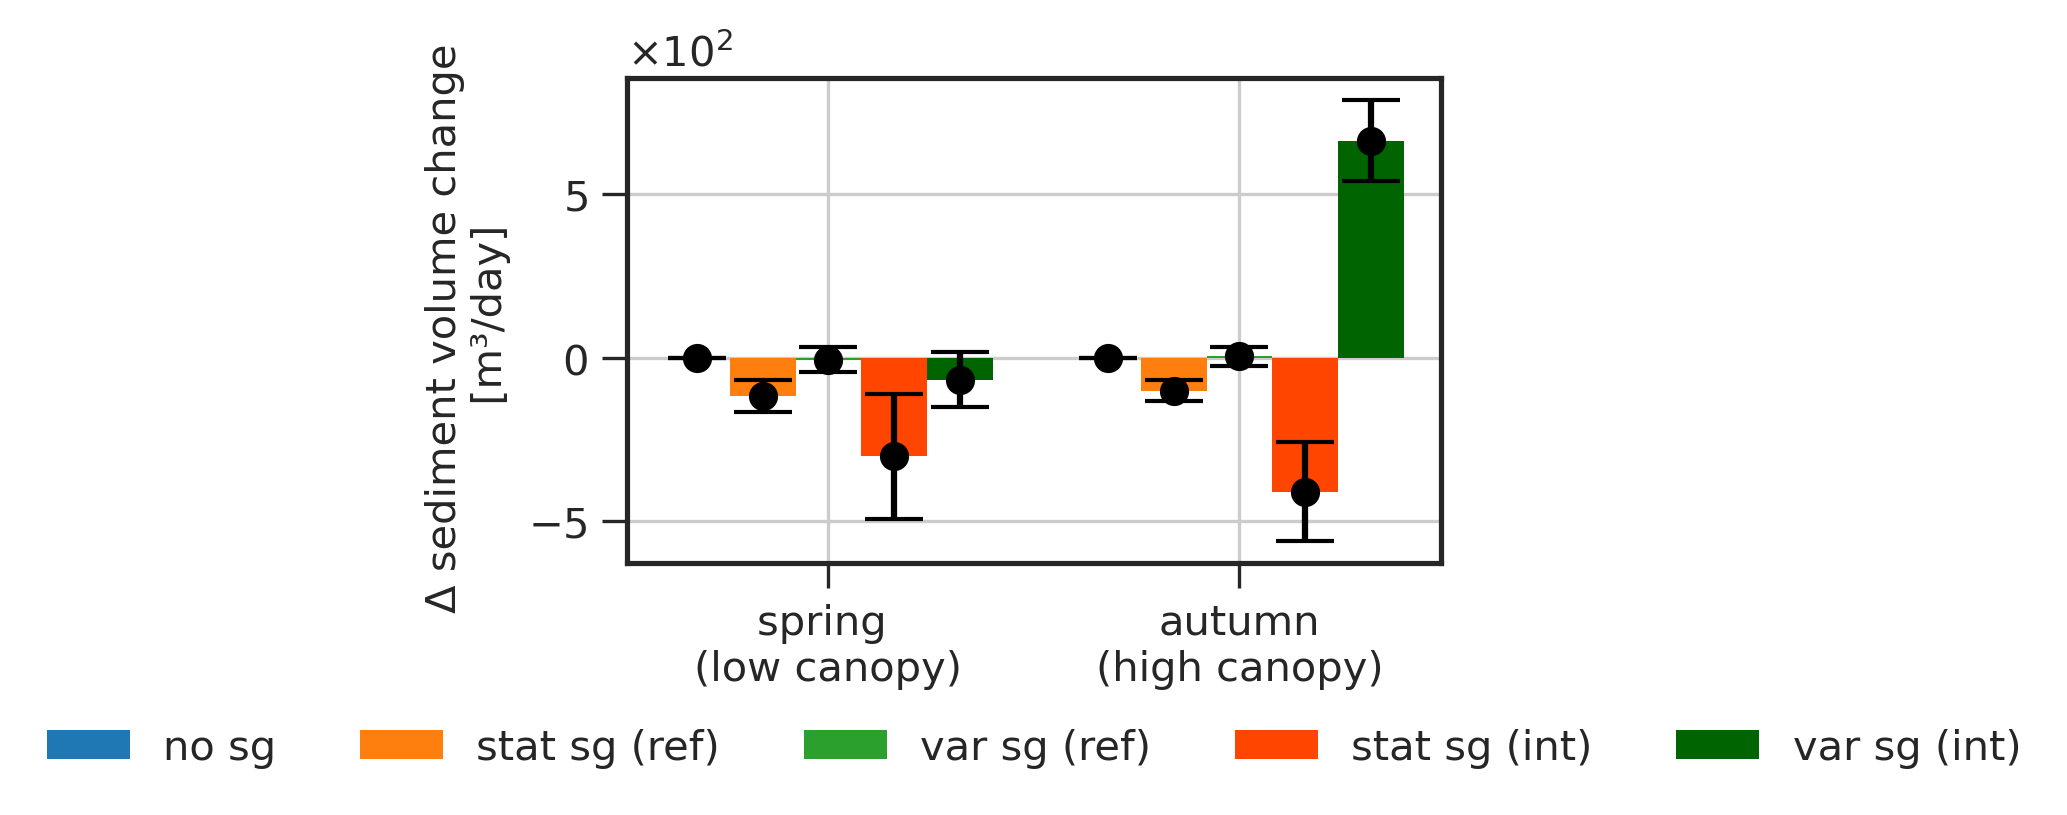

In [18]:
#all in one and pretty
#all intertidal

sections = ('spring \n(low canopy)','autumn\n(high canopy)')

x = np.arange(2)
width = (1-0.2)/len(runs)
multiplier = -1

plt.style.use('seaborn-ticks')
fig, ax = plt.subplots(layout='constrained')
fig.set_figheight(3)
fig.set_figwidth(5)
ax.grid()
for run in range(0,len(runs)):
    offset = width * multiplier
    rects = ax.bar(x+offset,np.sum(mean_erovol,1)[run,:],width,label=run_labels[run],color=colors[run])
    ax.errorbar(x+offset,np.sum(mean_erovol,1)[run,:],yerr=np.sum(rmsd_erovol,1)[run,:],fmt='o',color='k',capsize = 7)
    multiplier +=1
    
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel(u'Δ sediment volume change \n [m³/day]')
#ax.set_title('Volume change by season')
ax.set_xticks(x + width, sections)
#ax.set_ylim([-2.8e3,0.4e3])
ax.yaxis.get_major_formatter().set_powerlimits((0, 1))
#ax.yaxis.offsetText.set_fontsize(24)
ax.yaxis.get_major_formatter().set_useMathText('true')

#plt.tight_layout()
# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0 + box.width*0.2, box.y0 + box.height * 0.3,box.width*0.7, box.height * 0.7])
# Put a legend below current axis
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.5), fancybox=True, ncol=5)

plt.savefig(plotpat+ figname + '/daily_volume_change_sintertidal_allsub_seasons_'+ heights[2]+'_all_diff.png')
 

In [9]:
##### statistics spring:
print('outside meadows')
print('no seagrass total sed volume chage:',mean_erovol[0,0,0])
print('static seagrass total sed volume change:',mean_erovol[1,0,0])
print('variable seagrass total sed volume change:',mean_erovol[2,0,0])
print('perc. change static seagrass:', (mean_erovol[1,0,0]-mean_erovol[0,0,0])/mean_erovol[0,0,0])
print('perc. change variable seagrass:', (mean_erovol[2,0,0]-mean_erovol[0,0,0])/mean_erovol[0,0,0])

print('inside meadows (mid canopy height)')
print('no seagrass total sed volume chage:',mean_erovol[0,1,0])
print('static seagrass total sed volume change:',mean_erovol[1,1,0])
print('variable seagrass total sed volume change:',mean_erovol[2,1,0])
print('perc. change static seagrass:',(mean_erovol[1,1,0]-mean_erovol[0,1,0])/mean_erovol[0,1,0])
print('perc. change variable seagrass:', (mean_erovol[2,1,0]-mean_erovol[0,1,0])/mean_erovol[0,1,0])

print('inside meadows (high canopy height)')
print('no seagrass total sed volume chage:',mean_erovol[0,2,0])
print('static seagrass total sed volume change:',mean_erovol[1,2,0])
print('variable seagrass total sed volume change:',mean_erovol[2,2,0])
print('perc. change static seagrass:', (mean_erovol[1,2,0]-mean_erovol[0,2,0])/mean_erovol[0,2,0])
print('perc. change variable seagrass:', (mean_erovol[2,2,0]-mean_erovol[0,2,0])/mean_erovol[0,2,0])

print('inside meadows (total)')
print('no seagrass total sed volume chage:',mean_erovol[0,1,0]+mean_erovol[0,2,0])
print('static seagrass total sed volume change:',mean_erovol[1,1,0]+mean_erovol[1,2,0])
print('variable seagrass total sed volume change:',mean_erovol[2,1,0]+mean_erovol[2,2,0])
print('perc. change static seagrass:', (mean_erovol[1,1,0]+mean_erovol[1,2,0] -(mean_erovol[0,1,0]+mean_erovol[0,2,0]))/ mean_erovol[0,1,0]+mean_erovol[0,2,0])
print('perc. change variable seagrass:', (mean_erovol[2,1,0]+mean_erovol[2,2,0] -(mean_erovol[0,1,0]+mean_erovol[0,2,0]))/ mean_erovol[0,1,0]+mean_erovol[0,2,0])

outside meadows
no seagrass total sed volume chage: 0.0
static seagrass total sed volume change: -129.00193732179383
variable seagrass total sed volume change: -16.887043090538484
perc. change static seagrass: -inf
perc. change variable seagrass: -inf
inside meadows (mid canopy height)
no seagrass total sed volume chage: 0.0
static seagrass total sed volume change: 8.742877130993413
variable seagrass total sed volume change: 9.032695323689916
perc. change static seagrass: inf
perc. change variable seagrass: inf
inside meadows (high canopy height)
no seagrass total sed volume chage: 0.0
static seagrass total sed volume change: 4.094132075354357
variable seagrass total sed volume change: 1.7531999662682811
perc. change static seagrass: inf
perc. change variable seagrass: inf
inside meadows (total)
no seagrass total sed volume chage: 0.0
static seagrass total sed volume change: 12.83700920634777
variable seagrass total sed volume change: 10.785895289958198
perc. change static seagrass: in

/tmp/ipykernel_558807/432922091.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  print('perc. change static seagrass:', (mean_erovol[1,0,0]-mean_erovol[0,0,0])/mean_erovol[0,0,0])
/tmp/ipykernel_558807/432922091.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  print('perc. change variable seagrass:', (mean_erovol[2,0,0]-mean_erovol[0,0,0])/mean_erovol[0,0,0])
/tmp/ipykernel_558807/432922091.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  print('perc. change static seagrass:',(mean_erovol[1,1,0]-mean_erovol[0,1,0])/mean_erovol[0,1,0])
/tmp/ipykernel_558807/432922091.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  print('perc. change variable seagrass:', (mean_erovol[2,1,0]-mean_erovol[0,1,0])/mean_erovol[0,1,0])
/tmp/ipykernel_558807/432922091.py:20: RuntimeWarning: divide by zero encountered in double_scalars
  print('perc. change static seagrass:', (mean_erovol[1,2,0]-mean_erovol[0,2,0])/mean_erovol[0,

In [10]:
#statistics autumn:
print('outside meadows')
print('no seagrass total sed volume chage:',mean_erovol[0,0,1])
print('static seagrass total sed volume change:',mean_erovol[1,0,1])
print('variable seagrass total sed volume change:',mean_erovol[2,0,1])
print('perc. change static seagrass:', (mean_erovol[1,0,1]-mean_erovol[0,0,1])/mean_erovol[0,0,1])
print('perc. change variable seagrass:', (mean_erovol[2,0,1]-mean_erovol[0,0,1])/mean_erovol[0,0,1])

print('inside meadows (mid canopy height)')
print('no seagrass total sed volume chage:',mean_erovol[0,1,1])
print('static seagrass total sed volume change:',mean_erovol[1,1,1])
print('variable seagrass total sed volume change:',mean_erovol[2,1,1])
print('perc. change static seagrass:',(mean_erovol[1,1,1]-mean_erovol[0,1,1])/mean_erovol[0,1,1])
print('perc. change variable seagrass:', (mean_erovol[2,1,1]-mean_erovol[0,1,1])/mean_erovol[0,1,1])

print('inside meadows (high canopy height)')
print('no seagrass total sed volume chage:',mean_erovol[0,2,1])
print('static seagrass total sed volume change:',mean_erovol[1,2,1])
print('variable seagrass total sed volume change:',mean_erovol[2,2,1])
print('perc. change static seagrass:', (mean_erovol[1,2,1]-mean_erovol[0,2,1])/mean_erovol[0,2,1])
print('perc. change variable seagrass:', (mean_erovol[2,2,1]-mean_erovol[0,2,1])/mean_erovol[0,2,1])

print('inside meadows (total)')
print('no seagrass total sed volume chage:',mean_erovol[0,1,1]+mean_erovol[0,2,1])
print('static seagrass total sed volume change:',mean_erovol[1,1,1]+mean_erovol[1,2,1])
print('variable seagrass total sed volume change:',mean_erovol[2,1,1]+mean_erovol[2,2,1])
print('perc. change static seagrass:', (mean_erovol[1,1,1]+mean_erovol[1,2,1] -(mean_erovol[0,1,1]+mean_erovol[0,2,1]))/ mean_erovol[0,1,0]+mean_erovol[0,2,1])
print('perc. change variable seagrass:', (mean_erovol[2,1,1]+mean_erovol[2,2,1] -(mean_erovol[0,1,1]+mean_erovol[0,2,1]))/ mean_erovol[0,1,1]+mean_erovol[0,2,1])

outside meadows
no seagrass total sed volume chage: 0.0
static seagrass total sed volume change: -129.24070196243562
variable seagrass total sed volume change: -39.241100283559014
perc. change static seagrass: -inf
perc. change variable seagrass: -inf
inside meadows (mid canopy height)
no seagrass total sed volume chage: 0.0
static seagrass total sed volume change: 23.838417851287122
variable seagrass total sed volume change: 38.72603518453972
perc. change static seagrass: inf
perc. change variable seagrass: inf
inside meadows (high canopy height)
no seagrass total sed volume chage: 0.0
static seagrass total sed volume change: 5.515856286756191
variable seagrass total sed volume change: 5.3572670185876206
perc. change static seagrass: inf
perc. change variable seagrass: inf
inside meadows (total)
no seagrass total sed volume chage: 0.0
static seagrass total sed volume change: 29.354274138043312
variable seagrass total sed volume change: 44.08330220312734
perc. change static seagrass: i

/tmp/ipykernel_558807/3198422608.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  print('perc. change static seagrass:', (mean_erovol[1,0,1]-mean_erovol[0,0,1])/mean_erovol[0,0,1])
/tmp/ipykernel_558807/3198422608.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  print('perc. change variable seagrass:', (mean_erovol[2,0,1]-mean_erovol[0,0,1])/mean_erovol[0,0,1])
/tmp/ipykernel_558807/3198422608.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  print('perc. change static seagrass:',(mean_erovol[1,1,1]-mean_erovol[0,1,1])/mean_erovol[0,1,1])
/tmp/ipykernel_558807/3198422608.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  print('perc. change variable seagrass:', (mean_erovol[2,1,1]-mean_erovol[0,1,1])/mean_erovol[0,1,1])
/tmp/ipykernel_558807/3198422608.py:20: RuntimeWarning: divide by zero encountered in double_scalars
  print('perc. change static seagrass:', (mean_erovol[1,2,1]-mean_erovol[0,2,1])/mean_erov